(18,)
[[ 0.1004359   0.86805934]
 [ 0.135291   -0.01686616]
 [ 0.946503    0.01508554]
 [ 0.91164791  0.90001104]
 [ 0.1004359   0.86805934]]


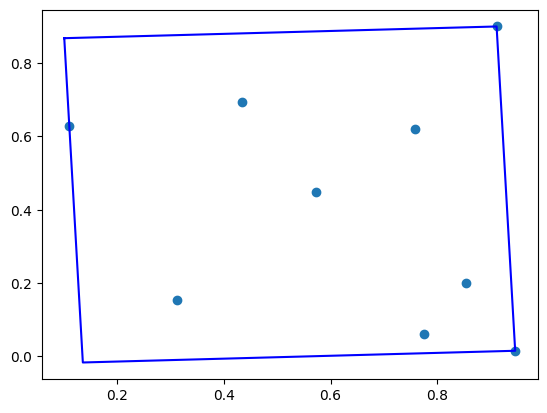

In [27]:
import matplotlib.pyplot as plt
import numpy as np
MAX_N = 20

def distance(a,b):
    return (a[0] - b[0])**2 + (a[1] - b[1])**2

def cross(o, a, b):
    return (a[0] - o[0])* (b[1] - o[1]) - \
           (a[1] - o[1])* (b[0] - o[0])

def rotate(angle, pointsets):
    """
    Params: 
        pointsets: -> Tensor [N, 2]
        angle: -> int
    Returns:
        
    """
    angle = angle * (np.pi/180)
    print(angle)
    # build rotation matrix
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    rotated_points = [np.matmul(pointsets[i,:], R) for i in range(pointsets.shape[0])]
    return np.array(rotated_points)

def rotate_by_matrix(R, pointsets):
    """
    Params: 
        pointsets: -> Tensor [N, 2]
        R: -> Tensor [2,2]
    """
    rotated_points = [np.matmul(R,pointsets[i,:]) for i in range(pointsets.shape[0])]
    return np.array(rotated_points)


def deg2rad(angle):
    return angle*np.pi/180

def rad2deg(angle):
    return angle*180/np.pi

def min_bounding_rect(convex_points):
    """
    Params:
        convex_points: -> Tensor [N, 2]
    """
    convex_num = convex_points.shape[0] # get convex number

    # prepare for calculating angle
    edges_angle = np.zeros(convex_num)

    convex_points = np.insert(convex_points, 0, convex_points[-1, :], axis=0)
    for i in range(convex_num):
        distances = convex_points[i, :] - convex_points[i+1, :]
        edges_angle[i] = np.arctan2(distances[1], distances[0]) 

        # fixing poistive angle and negative angle
        if edges_angle[i] >= 0:
            edges_angle[i] = np.fmod(edges_angle[i], np.pi/2)
        else:
            edges_angle[i] = edges_angle[i] - (int(edges_angle[i]/(np.pi/2) - 1)* (np.pi/2))
    convex_points = np.delete(convex_points, 0, axis=0) # remove starting point from pointset

    # prevent duplicate angle
    unique_flag = 0 # here is a flag, 1 presents no unique edge found in this iteration, 0 presents there is one unique edge
    unique_angle = np.zeros(MAX_N) # this array is used to store unique angle informaton
    unique_angle[0] = edges_angle[0]
    n_unique = 1 # inital unique edge number
    n_edge = convex_num

    for i in range(n_edge):
        for j in range(n_unique):
            if edges_angle[i] == unique_angle[j]:
                unique_flag += 1
        # unique edge found
        if unique_flag == 0:
            unique_angle[n_unique] = edges_angle[i]
            n_unique += 1
            unique_flag = 0
        else:
            unique_flag = 0
    
    # used to record min_area
    min_area = np.inf
    ret = np.zeros(5)

    # for each unique edge, we need to build a rouation matrix, and compute the area of boundary rectangular
    for i in range(n_unique):
        # build rotation matrix
        R = np.zeros([2,2])
        R[0][0] = np.cos(unique_angle[i])
        R[1][0] = -np.sin(unique_angle[i])
        R[1][1] = np.cos(unique_angle[i])
        R[0][1] = np.sin(unique_angle[i])

        # rotate points according rotatioin matrix
        rotated_points = rotate_by_matrix(R, convex_points)

        # record the extreme value
        x_min, y_min, x_max, y_max = np.inf, np.inf, np.NINF, np.NINF
        for j in range(convex_num):
            if rotated_points[j, 0] < x_min:
                x_min = rotated_points[j, 0]

            if rotated_points[j, 0] > x_max:
                x_max = rotated_points[j, 0]

            if rotated_points[j, 1] < y_min:
                y_min = rotated_points[j, 1]

            if rotated_points[j, 1] > y_max:
                y_max = rotated_points[j, 1]

        area = (x_max - x_min) * (y_max - y_min)
        # update min area rectangular
        if area <= min_area:
            min_area = area
            ret[0] = unique_angle[i]
            ret[1] = x_min
            ret[2] = y_min
            ret[3] = x_max
            ret[4] = y_max
    return ret

def jarvis(pointsets, N=9):
    """
    Params: 
        pointsets: -> Tensur, [18]
        N: -> int, number of points in pointset
    Return:
        result: -> Tensor, [N, 2], N is the convex number
    """
    # conver [18] -> point matrix array [N/2, 2]
    point_arr = [[pointsets[2*i], pointsets[2*i+1]] for i in range(N)]
    point_arr = np.array(point_arr[:])

    left_idx = np.argmin(point_arr[:,0]) # the most left element

    # CCW searching
    start_idx = left_idx
    result_idx = []
    while True:
        result_idx.append(start_idx) # add convex to result list
        
        # random select a next point(never select start point as next point)
        next_idx = left_idx 
        # use loop searching next convex
        for i in range(N):
            # keep others point on the right side of start -> point_arr[i]
            sign = cross(point_arr[start_idx], point_arr[i], point_arr[next_idx])
            if sign > 0 or \
               (sign == 0 and\
               (distance(point_arr[result_idx[-1],:], point_arr[i]) > \
                distance(point_arr[result_idx[-1],:], point_arr[next_idx]))):
                next_idx = i
        
        start_idx = next_idx

        if start_idx == left_idx:
            break
    result = [point_arr[i] for i in result_idx] 
    return np.array(result)

def min_area_rect(pointsets):
    """
    Params:
        pointsets: -> Tensor [2N], N is the number of points, [x1, y1, x2, y2, ... ,xN , yN]
    Return:
        ret: -> Tenosr [4, 2] : [[x1, y1],
                                 [x2, y2],
                                 [x3, y3],
                                 [x4, y4]]
    """
    pointsets = jarvis(pointsets)
    result = min_bounding_rect(pointsets)
    pointsets = np.insert(pointsets, 0, pointsets[-1, :], axis=0)

    # split
    angle = result[0]
    # angle = rad2deg(angle)

    x_min = result[1]
    y_min = result[2]
    x_max = result[3]
    y_max = result[4]

    R = np.zeros([2,2])
    R[0][0] = np.cos(-angle)
    R[1][1] = np.cos(-angle)
    R[1][0] = -np.sin(-angle)
    R[0][1] = np.sin(-angle)

    left_bot = [x_min, y_min]
    right_bot = [x_max, y_min]
    left_top = [x_min, y_max]
    right_top = [x_max, y_max]
    min_points = np.array([left_bot, right_bot, right_top,left_top])
    rotated_points = rotate_by_matrix(R, min_points)

    return rotated_points



# test_data = np.random.random(18)
test_data = np.array([-1,0,3,1,3,3,2,3,2,3,2,3,2,3,2,6,4,1])
test_data = np.random.random(18)
plt.plot(test_data[::2], test_data[1::2], 'o')
# rotated_points = jarvis(test_data)
print(test_data.shape)
rotated_points = min_area_rect(test_data)
rotated_points = np.insert(rotated_points, 0, rotated_points[-1], axis = 0)
print(rotated_points)

plt.plot(rotated_points[:,0], rotated_points[:,1],'b')

In [ ]:
a = np.array([0,0])
b = np.array([0,2])
c = np.array([0,4])
d = np.array([-1,4])
plt.plot([0,0,0,-1],[0,2,4,4],'o')
cross(a,b,d)

In [ ]:
result.shape

In [ ]:
def rotate_by_matrix(R, pointsets):
    """
    Params: 
        pointsets: -> Tensor [N, 2]
        R: -> Tensor [2,2]
    """
    rotated_points = [np.matmul(R,pointsets[i,:]) for i in range(pointsets.shape[0])]
    return np.array(rotated_points)

def rotate_by_angle(angle, pointsets):
    """
    Params: 
        pointsets: -> Tensor [N, 2]
        angle: -> int
    """
    angle = angle * (np.pi/180)
    # build rotation matrix
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    
    rotated_points = [np.matmul(pointsets[i,:], R) for i in range(pointsets.shape[0])]
    return np.array(rotated_points)
test_pts = np.array([[0,0],[2,0],[1,np.sqrt(3)],[0,0]])
test_pts = np.array([[-1,np.sqrt(3)],[0,0],[1, np.sqrt(3)],[-1,np.sqrt(3)]])

# test_pts = np.array([[3,1],[5,2],[1,2],[4,2], [2,0]])
# result_rotate = rotate(180, test_pts)
R = np.zeros([2,2])
angle = 60
R[0][0] = np.cos(angle* np.pi/180)
R[1][0] = -np.sin(angle* np.pi/180)
R[1][1] = np.cos(angle* np.pi/180)
R[0][1] = np.sin(angle* np.pi/180)
result_rotate = rotate_by_matrix(R, test_pts)

plt.plot(test_pts[:,0], test_pts[:,1],'b')
plt.plot(result_rotate[:,0], result_rotate[:,1],'r')
plt.show

In [ ]:
o = [1,5]
a = [2,2]
b = [4,4]
c = [1,3]
d = [1.5,3.5]

plt.plot(*o,'ro')
plt.plot(*a,'bo')
plt.plot(*b,'go')
plt.plot(*c,'o')
plt.plot(*d,'o')

plt.text(*o, 'o')
plt.text(*a, 'a')
plt.text(*b, 'b')
plt.text(*c, 'c')
plt.text(*d, 'c')

plt.plot([1,2],[5,2]) # [o,a]
plt.plot([1,4],[5,4]) # [o,b]
plt.plot([1,1],[5,3]) # [o,c]
print(cross(o,a,b))
print(cross(o,a,c))
print(cross(o,a,d))
plt.show()

In [ ]:
MAX_N = 20
def deg2rad(angle):
    return angle*np.pi/180

def rad2deg(angle):
    return angle*180/np.pi

def min_bounding_rect(convex_points):
    """
    Params:
        convex_points: -> Tensor [N, 2]
    """
    convex_num = convex_points.shape[0] # get convex number

    # prepare for calculating angle
    edges_angle = np.zeros(convex_num)

    convex_points = np.insert(convex_points, 0, convex_points[-1, :], axis=0)
    for i in range(convex_num):
        distances = convex_points[i, :] - convex_points[i+1, :]
        edges_angle[i] = np.arctan2(distances[1], distances[0]) 
        # print(f"angle: {rad2deg(edges_angle[i])} -> {convex_points[i, :]} - {convex_points[i+1, :]} =  {distances}")

        # fixing poistive angle and negative angle
        if edges_angle[i] >= 0:
            edges_angle[i] = np.fmod(edges_angle[i], np.pi/2)
        else:
            edges_angle[i] = edges_angle[i] - (int(edges_angle[i]/(np.pi/2) - 1)* (np.pi/2))
        # print(f"after fixing: {rad2deg(edges_angle[i])} \n")
    convex_points = np.delete(convex_points, 0, axis=0) # remove starting point from pointset

    # prevent duplicate angle
    unique_flag = 0 # here is a flag, 1 presents no unique edge found in this iteration, 0 presents there is one unique edge
    unique_angle = np.zeros(MAX_N) # this array is used to store unique angle informaton
    unique_angle[0] = edges_angle[0]
    n_unique = 1 # inital unique edge number
    n_edge = convex_num

    for i in range(n_edge):
        for j in range(n_unique):
            if edges_angle[i] == unique_angle[j]:
                unique_flag += 1
        # unique edge found
        if unique_flag == 0:
            unique_angle[n_unique] = edges_angle[i]
            n_unique += 1
            unique_flag = 0
        else:
            unique_flag = 0
    
    # used to record min_area
    min_area = np.inf
    ret = np.zeros(5)

    # for each unique edge, we need to build a rouation matrix, and compute the area of boundary rectangular
    record_points = None

    for i in range(n_unique):
        # build rotation matrix
        R = np.zeros([2,2])
        R[0][0] = np.cos(unique_angle[i])
        R[1][0] = -np.sin(unique_angle[i])
        R[1][1] = np.cos(unique_angle[i])
        R[0][1] = np.sin(unique_angle[i])

        # rotate points according rotatioin matrix
        rotated_points = rotate_by_matrix(R, convex_points)
        print(f"looping rotated points {rad2deg(unique_angle[i])}: \n{rotated_points}\n")

        # record the extreme value
        x_min, y_min, x_max, y_max = np.inf, np.inf, np.NINF, np.NINF
        for j in range(convex_num):
            if rotated_points[j, 0] < x_min:
                x_min = rotated_points[j, 0]

            if rotated_points[j, 0] > x_max:
                x_max = rotated_points[j, 0]

            if rotated_points[j, 1] < y_min:
                y_min = rotated_points[j, 1]

            if rotated_points[j, 1] > y_max:
                y_max = rotated_points[j, 1]

        area = (x_max - x_min) * (y_max - y_min)
        # update min area rectangular
        if area <= min_area:
            record_points = rotated_points
            min_area = area
            ret[0] = unique_angle[i]
            ret[1] = x_min
            ret[2] = y_min
            ret[3] = x_max
            ret[4] = y_max

    record_points = np.insert(record_points, 0, record_points[-1, :], axis=0)
    print(f"rotated_point: {record_points}")
    print(f"final angle is: {rad2deg(ret[0])}")
    print(f"ret: {ret[1:]}")
    # print(f"angle list: {rad2deg(unique_angle)}")
    plt.plot(record_points[:,0], record_points[:,1], 'g')
    return ret

# pointsets = np.array([[-1,np.sqrt(3)],[0,0],[1, np.sqrt(3)]])
# pointsets = np.array([[0.05861594,0.4610133 ],
#                       [0.4610133 ,0.99472645],
#                       [0.99472645,0.71029443],
#                       [0.83511264,0.42715204],
#                       [0.42715204,0.40719027]])
input = np.random.random(18)
plt.plot(input[::2],input[1::2],'o')
pointsets = jarvis(input, int(input.shape[0]/2)+1)
result = min_bounding_rect(pointsets)
pointsets = np.insert(pointsets, 0, pointsets[-1, :], axis=0)

# split
angle = result[0]
# angle = rad2deg(angle)

x_min = result[1]
y_min = result[2]
x_max = result[3]
y_max = result[4]

R = np.zeros([2,2])
R[0][0] = np.cos(-angle)
R[1][1] = np.cos(-angle)
R[1][0] = -np.sin(-angle)
R[0][1] = np.sin(-angle)

left_bot = [x_min, y_min]
right_bot = [x_max, y_min]
left_top = [x_min, y_max]
right_top = [x_max, y_max]

min_points = np.array([left_bot, right_bot, right_top,left_top])
min_points = np.insert(min_points, 0, min_points[-1], axis =0)
rotated_points = rotate_by_matrix(R, min_points)

rotated_points = min_area_rect(input)
rotated_points = np.insert(rotated_points, 0, rotated_points[-1], axis =0)

plt.plot(min_points[:,0], min_points[:,1], 'black')
plt.plot(rotated_points[:,0], rotated_points[:,1],'b')
plt.plot(pointsets[:,0], pointsets[:,1],'r')
plt.show()